# Introduction

The following code implements a solution to the multiclass classification problem of assigning an iris flower to its species based on the size of its petals and sepals. The Iris flower data set consists of 50 samples from each of three species: *Iris setosa*, *Iris virginica* and *Iris versicolor*. In this case, data set was simulated to be gathered neglectfully, which resulted in some faulty values that needed to be fixed before training a model.

The data set is not large nor especially complex, which enables the use of rather simple machine learning algorithms of classification (as opposed to deep learning methods, for example neural networks). In this project, 5 different algorithms were trained and compared in order to find the one offering the best quality of fit and simplicity. The final model's performance was then assessed and reported.

The code for this project was implemented using scikit-learn library. Aurélien Géron's "Hands-On Machine Learning with Scikit-Learn and Tensorflow" was primarly used as a reference.

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
def load_data(data_path, filename, separator = ",", header = None, index_col = None):
    file_path = os.path.join(data_path, filename)
    return pd.read_csv(file_path, sep = separator, header = header, index_col = index_col)

In [4]:
input_data = load_data(os.path.abspath(''), 
                       'Graduate - IRISES dataset (2019-06).csv', 
                       separator = "|", 
                       header = 0,
                       index_col = 0)

input_data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [5]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
Sepal.Length    150 non-null float64
Sepal.Width     149 non-null float64
Petal.Length    150 non-null float64
Petal.Width     150 non-null object
Species         150 non-null object
dtypes: float64(3), object(2)
memory usage: 7.0+ KB


The data set was inspected to contain 5 columns, 4 with flowers' features and 1 with their labels. Firstly, 'Petal.Width' feature was imported as an 'object' type, even though it is a regular float64 value. That needed to be fixed before continuing with data exploration. 

In [6]:
input_data['Petal.Width'] = pd.to_numeric(input_data['Petal.Width'], errors = 'coerce')

input_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
Sepal.Length    150 non-null float64
Sepal.Width     149 non-null float64
Petal.Length    150 non-null float64
Petal.Width     149 non-null float64
Species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [7]:
nan_rows_sepwidth = input_data[input_data['Sepal.Width'].isnull()]
nan_rows_petwidth = input_data[input_data['Petal.Width'].isnull()]
print(nan_rows_sepwidth)
print('------------------')
print(nan_rows_petwidth)

    Sepal.Length  Sepal.Width  Petal.Length  Petal.Width     Species
82           5.5          NaN           3.7          1.0  versicolor
------------------
     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width    Species
133           6.4          2.8           5.6          NaN  virginica


In [8]:
input_data.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,149.000000,150.000000,149.000000
mean,5.779333,3.061745,3.758000,1.192617
std,1.197721,0.433963,1.765298,0.760343
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


At this point, two problems become apparent. Firstly, numeric data contained NaN values which needed to be replaced before training a model. Secondly, the minimum of 'Sepal.Length' was -4.8, which was not an acceptable value since it represented length. It needed to always be higher than 0. It can be assumed that the minus sign was put there as a mistake, and a value of 4.8 was valid (it falls less than one standard deviation from the mean of the column). These errors needed to be taken into consideration in the later stage of data preprocessing.

Moving on, it was noticed that labels are represented as strings. To train a model, they needed to be transformed into integers. The important observation was that the number of samples in each class was equal.

In [9]:
input_data['Species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: Species, dtype: int64

In [10]:
def LabelToInteger(label):
    if label == 'virginica':
        return 1
    if label == 'versicolor':
        return 2
    if label == 'setosa':
        return 3
    
label_mapper = {1 : 'Virginica', 2 : 'Versicolor', 3 : 'Setosa'}

input_data['Species'] = input_data['Species'].apply(LabelToInteger)

input_data['Species'].head()

1    3
2    3
3    3
4    3
5    3
Name: Species, dtype: int64

## Data visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b71b0828>,
      dtype=object)

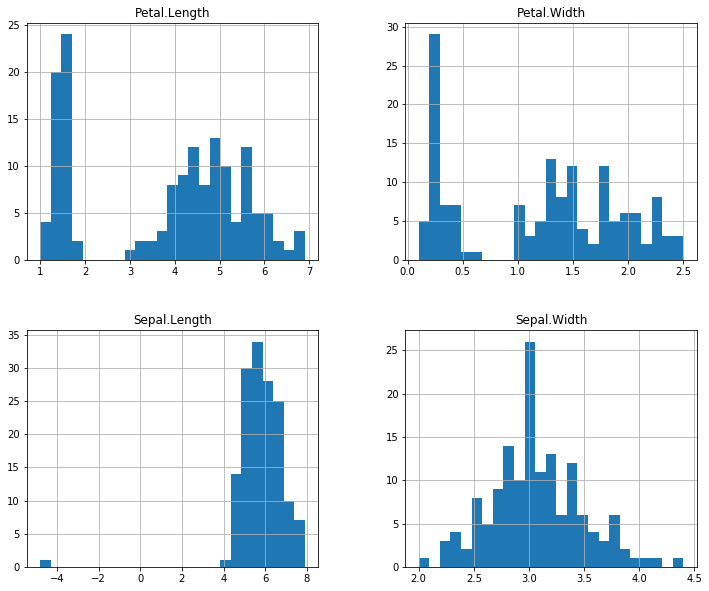

In [11]:
input_data.hist(column = ['Petal.Length', 'Petal.Width', 'Sepal.Length', 'Sepal.Width'],
                bins = 25, figsize = (12, 10))

The histograms of features were visualized to further inspect the properties of their distributions. It can be noticed that petals' sizes are divisible into two subgroups: 1"-2" and about 3"-7" for length and 0.1"-0.6" and 1"-2.5" for width. This characteristic can be an important factor in classification. Sepal length and sepal width are closer to being bell-shaped. What's more, the one sample mistakenly labeled as having negative sepal length is clearly visible. 

Before moving on, the input set needed to be split into training and test sets. To ensure equal distribution of output classes in both sets, StratifiedShuffleSplit class was used. The data was split with 0.2 ratio, which led to 120 samples falling in the training set and 30 samples in the test set. Each classes' examples make up 1/3 of each set.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

equal_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_id, test_id in equal_split.split(input_data, input_data['Species']):
    train_set = input_data.loc[train_id + 1]
    test_set = input_data.loc[test_id + 1]
    
test_set['Species'].value_counts()

3    10
2    10
1    10
Name: Species, dtype: int64

In [13]:
irises_train = train_set.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8a9241c50>,
      dtype=object)

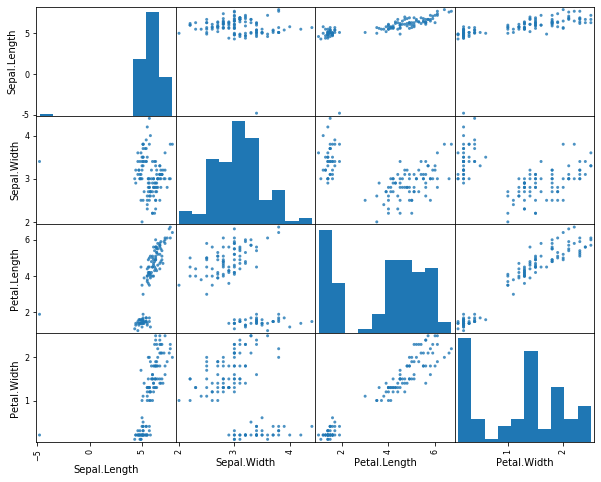

In [14]:
from pandas.plotting import scatter_matrix

attributes = ["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"]
scatter_matrix(irises_train[attributes], alpha = 0.8, figsize = (10, 8), grid = True)

In order to obtain more information about the relationships of features, a *scatter matrix* was visualized. This function plots features against each other, which is helpful for discovering correlated attributes. In this case, it is apparent that e.g. petal's width and length are strongly tied which each other. The same applies to petal's and sepal's lengths. These relationships were visualized in a way to distinguish each classes' samples.

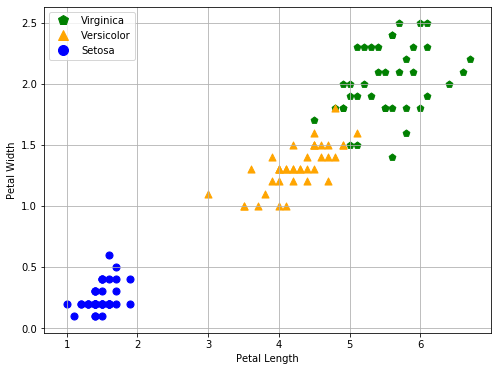

In [15]:
import matplotlib.pyplot as plt
import matplotlib.lines as matlines
%matplotlib inline

pg = matlines.Line2D([], [], color = 'green', marker = 'p', 
                     linestyle = 'None', markersize = 10, label = label_mapper[1])
to = matlines.Line2D([], [], color = 'orange', marker = '^', 
                     linestyle = 'None', markersize = 10, label = label_mapper[2])
og = matlines.Line2D([], [], color = 'blue', marker = 'o', 
                     linestyle = 'None', markersize = 10, label = label_mapper[3])

plt.figure(figsize = (8, 6))
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 1], 
            irises_train['Petal.Width'].loc[irises_train['Species'] == 1],
            s = 50, color = 'green', marker = 'p')
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 2], 
            irises_train['Petal.Width'].loc[irises_train['Species'] == 2], 
            s = 50, color = 'orange', marker = '^')
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 3], 
            irises_train['Petal.Width'].loc[irises_train['Species'] == 3], 
            s = 50, color = 'blue', marker = 'o')
plt.legend(handles = [pg, to, og], loc = 'upper left')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.grid(True)
plt.show()

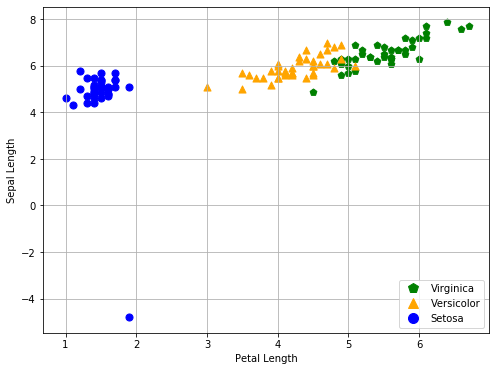

In [16]:
plt.figure(figsize = (8, 6))
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 1], 
            irises_train['Sepal.Length'].loc[irises_train['Species'] == 1],
            s = 50, color = 'green', marker = 'p')
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 2], 
            irises_train['Sepal.Length'].loc[irises_train['Species'] == 2], 
            s = 50, color = 'orange', marker = '^')
plt.scatter(irises_train['Petal.Length'].loc[irises_train['Species'] == 3], 
            irises_train['Sepal.Length'].loc[irises_train['Species'] == 3], 
            s = 50, color = 'blue', marker = 'o')
plt.legend(handles = [pg, to, og], loc = 'lower right')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Length')
plt.grid(True)
plt.show()

The visualization brought a lot of new information: it is easy to notice that the three sets are almost perfectly linearly separable. The only possible confusion can occur regarding a few *virginica* / *versicolor* samples - it is impossible to assign a linear decision boundary to correctly and fully separate them (at least in spaces examined here). *Setosa* samples are clearly clustered. There should not be any problems correctly classifying them. 

## Data preprocessing

As a next step, a data processing pipeline was implemented to prepare the training set for use in machine learning algorithms. DataFrameSelector class was drawn from the book mentioned in the introduction and its puropse is to convert Pandas DataFrame into an iterable structure suitable for scikit-learn methods. NegativeValTransformer takes care of negative and zero values in the data set - it flips the sign if a value is less than 0, and returns NaN if it is equal to 0. The pipeline also consits of SimpleImputer - a class which fills missing values in the set. In this case, if it finds NaN, it changes it into a positive value equal to the median of the current column. StandardScaler standarizes features by subtracting the mean and scaling to unit variance. This step is often necessary to achieve satisfactory performance of the model, e.g. in the case of support vector machines.

With the data set this small these operations could have been performed manually as well. Writing functions seems to be a better practice since they operate in the same way even on sets that are too large to by handled by hand.

In [17]:
irises_feats = irises_train.drop('Species', axis = 1)
irises_labels = irises_train['Species'].copy()

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names = None):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if self.attribute_names != None:
            return X[self.attribute_names].values
        else:
            return X.values
        

class NegativeValTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names = None):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def val_trans(self, num):
        if num < 0:
            return -num
        if num == 0:
            return np.nan
        if num > 0:
            return num
    def transform(self, X):
        if self.attribute_names != None:
            X[self.attribute_names] = X[self.attribute_names].apply(self.val_trans)
        else:
            for column in X.columns:
                X[column] = X[column].apply(self.val_trans)
        return X

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

features_pipeline = Pipeline([('negative_transformer', NegativeValTransformer('Sepal.Length')),
                              ('selector', DataFrameSelector()), 
                              ('imputer', SimpleImputer(strategy = "median")),
                              ('standard_scaler', StandardScaler()),
                             ])
irises_feats_transformed = features_pipeline.fit_transform(irises_feats)

In [26]:
print('NaN elements in features: ', np.isnan(np.sum(irises_feats_transformed)))

NaN elements in features:  False


In [27]:
irises_feats_transformed.shape

(120, 4)

## Model choice

After data was cleaned and transformed, it was possible to begin the process of choosing the right machine learning model. 5 different algorithms were chosen to be assessed: multinomial logistic regression (softmax regression), linear support vector classification, decision tree classification and two ensemble learning methods: hard voting classifier using 3 previous methods and random decision forest. The hyperparameters at that step were mostly set to default. 5-fold cross-validation was used to test the models, and accuracy was used as a main metric.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

softmax_cls = LogisticRegression(C = 10.0, solver = 'lbfgs', multi_class = 'multinomial')

cross_val_score(softmax_cls, irises_feats_transformed, irises_labels, cv = 5, scoring = 'accuracy')

array([1.        , 0.91666667, 0.95833333, 0.95833333, 0.95833333])

In [30]:
from  sklearn.svm import LinearSVC

svm_cls = LinearSVC(loss = 'hinge', C = 10.0, multi_class = 'ovr', max_iter = 10000)

cross_val_score(svm_cls, irises_feats_transformed, irises_labels, cv = 5, scoring = 'accuracy')

array([0.95833333, 0.875     , 0.91666667, 0.875     , 0.95833333])

In [31]:
from sklearn.tree import DecisionTreeClassifier

dtree_cls = DecisionTreeClassifier(splitter = 'best', max_depth = 2)

cross_val_score(dtree_cls, irises_feats_transformed, irises_labels, cv = 5, scoring = 'accuracy')

array([0.91666667, 0.91666667, 0.95833333, 0.91666667, 0.95833333])

In [32]:
from sklearn.ensemble import VotingClassifier

voting_cls = VotingClassifier(estimators = [('softmax', softmax_cls), 
                                            ('svm', svm_cls), 
                                            ('dectree', dtree_cls)], voting = 'hard')

cross_val_score(voting_cls, irises_feats_transformed, irises_labels, cv = 5, scoring = 'accuracy')

array([1.        , 0.91666667, 0.95833333, 0.91666667, 0.95833333])

In [33]:
from sklearn.ensemble import RandomForestClassifier

rndforest_cls = RandomForestClassifier(n_estimators = 100, max_depth = 2, n_jobs = -1)

cross_val_score(rndforest_cls, irises_feats_transformed, irises_labels, cv = 5, scoring = 'accuracy')

array([0.875     , 0.91666667, 0.95833333, 0.95833333, 1.        ])

It turns out that all of the models perform very well, being close to perfect with their predictions. This fact provides relative liberty when it comes to deciding on the final algorithm. Given simplicity of the architecture and very high, consistent accuracy scores, **softmax regression** was used as a final method.

## Hyperparameter tuning

Grid search method was used to find the optimal parameters for the LogisticRegression class. In particular, the elements chosen to be tuned were: *C*, the inverse of regularization strength (high values indicate less regularization), *fit_intercept*, a constant added to the decision function and a *solver* function. The scores were then listed to provide a way to compare results. 

In [34]:
from sklearn.model_selection import GridSearchCV

parameters_grid = [ {'C' : [0.1, 1, 10, 100], 'fit_intercept' : [True, False], 
                     'solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'], 'max_iter' : [10000], 
                     'warm_start' : [False]} ]

grid_search_cv = GridSearchCV(softmax_cls, parameters_grid, cv = 5, scoring = 'accuracy')

grid_search_cv.fit(irises_feats_transformed, irises_labels)

results = grid_search_cv.cv_results_

for accuracy, parameters in zip(results['mean_test_score'], results['params']):
    print('Score: ', round(accuracy, 5), parameters)

Score:  0.88333 {'C': 0.1, 'fit_intercept': True, 'max_iter': 10000, 'solver': 'lbfgs', 'warm_start': False}
Score:  0.88333 {'C': 0.1, 'fit_intercept': True, 'max_iter': 10000, 'solver': 'newton-cg', 'warm_start': False}
Score:  0.88333 {'C': 0.1, 'fit_intercept': True, 'max_iter': 10000, 'solver': 'sag', 'warm_start': False}
Score:  0.88333 {'C': 0.1, 'fit_intercept': True, 'max_iter': 10000, 'solver': 'saga', 'warm_start': False}
Score:  0.84167 {'C': 0.1, 'fit_intercept': False, 'max_iter': 10000, 'solver': 'lbfgs', 'warm_start': False}
Score:  0.84167 {'C': 0.1, 'fit_intercept': False, 'max_iter': 10000, 'solver': 'newton-cg', 'warm_start': False}
Score:  0.84167 {'C': 0.1, 'fit_intercept': False, 'max_iter': 10000, 'solver': 'sag', 'warm_start': False}
Score:  0.84167 {'C': 0.1, 'fit_intercept': False, 'max_iter': 10000, 'solver': 'saga', 'warm_start': False}
Score:  0.94167 {'C': 1, 'fit_intercept': True, 'max_iter': 10000, 'solver': 'lbfgs', 'warm_start': False}
Score:  0.94167

In [35]:
grid_search_cv.best_params_

{'C': 10,
 'fit_intercept': True,
 'max_iter': 10000,
 'solver': 'lbfgs',
 'warm_start': False}

## Model testing

The chosen, tuned final model was then used to predict classes for the training and test sets. The metrics used were accuracy and a confusion matrix. Of course, the test set was also transformed with the existing pipeline.

In [36]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def confusion_matrix_format(predicted_labels, labels):
    
    confusion_mx = confusion_matrix(labels, predicted_labels)
    confusion_frame = pd.DataFrame(confusion_mx, 
                                   index = ['T Virginica', 'T Versicolor', 'T Setosa'], 
                                   columns = ['P Virginica', 'P Versicolor', 'P Setosa'])

    return confusion_frame

final_model = grid_search_cv.best_estimator_

irises_labels_predictions = final_model.predict(irises_feats_transformed)
final_test_score = accuracy_score(irises_labels, irises_labels_predictions)

print('Final accuracy of the model for the training set: ', final_test_score, '\n')
confusion_matrix_format(irises_labels_predictions, irises_labels)

Final accuracy of the model for the training set:  0.975 



,P Virginica,P Versicolor,P Setosa
T Virginica,39,1,0
T Versicolor,2,38,0
T Setosa,0,0,40


In [37]:
test_feats = test_set.drop('Species', axis = 1)
test_labels = test_set['Species'].copy()

test_feats_transformed = features_pipeline.transform(test_feats)

test_labels_predictions = final_model.predict(test_feats_transformed)

final_test_score = accuracy_score(test_labels, test_labels_predictions)

print('Final accuracy of the model for the test set: ', final_test_score, '\n')
confusion_matrix_format(test_labels_predictions, test_labels)

Final accuracy of the model for the test set:  0.9666666666666667 



,P Virginica,P Versicolor,P Setosa
T Virginica,10,0,0
T Versicolor,1,9,0
T Setosa,0,0,10


# Summary

The model performed very well, achieving **97.5% accuracy for the training set and 96.7% accuracy for the test set**. As it turned out, classes in the data set were quite easily separable without the use of advanced and computionally expensive methods. The analysis of confusion matrices confirms previous conclusions: the model confused only the flowers belonging to *virginica* and *versicolor* classes, predicting the correct label for *setosa* flowers with 100% accuracy. Frankly, it seems that improving the model further in terms of accuracy of predictions is not really possible. Methods to test in the case of this data set include deeper inspection of ensemble methods that usually provide the highest scores and introduction of some combinations of features. Trying to retrieve missing data could help as well, but since the number of faulty values is very small it would not cause any drastical improvement.